Using some motivation from `stream-impactor`...

In [26]:
import os
import pickle
import warnings

import astropy.coordinates as coord
import astropy.table as at
import astropy.units as u
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

# gala
import gala.coordinates as gc
import gala.integrate as gi
import gala.dynamics as gd
import gala.potential as gp
from gala.units import galactic

with warnings.catch_warnings():
    warnings.filterwarnings("ignore")
    galcen_frame_nosunv = coord.Galactocentric(z_sun=0*u.kpc, 
                                               galcen_v_sun=[0,0,0]*u.km/u.s)

In [32]:
gd1_skypos = at.Table.read('/Users/apricewhelan/projects/gd1-dr2/data/gd1-better-selection.fits')
mask = gd1_skypos['sliding_gi_cmd_mask'] & gd1_skypos['sliding_pm_mask'] & (gd1_skypos['stream_prob'] > 0.25)
gd1_skypos = gd1_skypos[mask]

In [2]:
with open('../spur-hacks/galcen.pkl', 'rb') as f:
    galcen_frame = pickle.load(f)

In [4]:
gd1_w0 = gd.PhaseSpacePosition.from_hdf5('../spur-hacks/w0.hdf5')

In [8]:
potential = gp.load('../spur-hacks/potential.yml')
H = gp.Hamiltonian(potential)

/Users/apricewhelan/projects/gala/gala/potential/potential/io.py:201: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  p_dict = yaml.load(fil.read())


In [7]:
progenitor_potential = gp.PlummerPotential(m=1.5e4*u.Msun, 
                                           b=5*u.pc,
                                           units=galactic)

In [17]:
df = gd.FardalStreamDF(lead=True, trail=False)
gen = gd.MockStreamGenerator(df, H, progenitor_potential=progenitor_potential)

In [18]:
%%time
fiducial_stream, _ = gen.run(gd1_w0, prog_mass=1.5e4*u.Msun,
                             dt=-0.2, t1=0, t2=-6*u.Gyr, n_particles=1)

CPU times: user 1min 12s, sys: 224 ms, total: 1min 12s
Wall time: 1min 12s


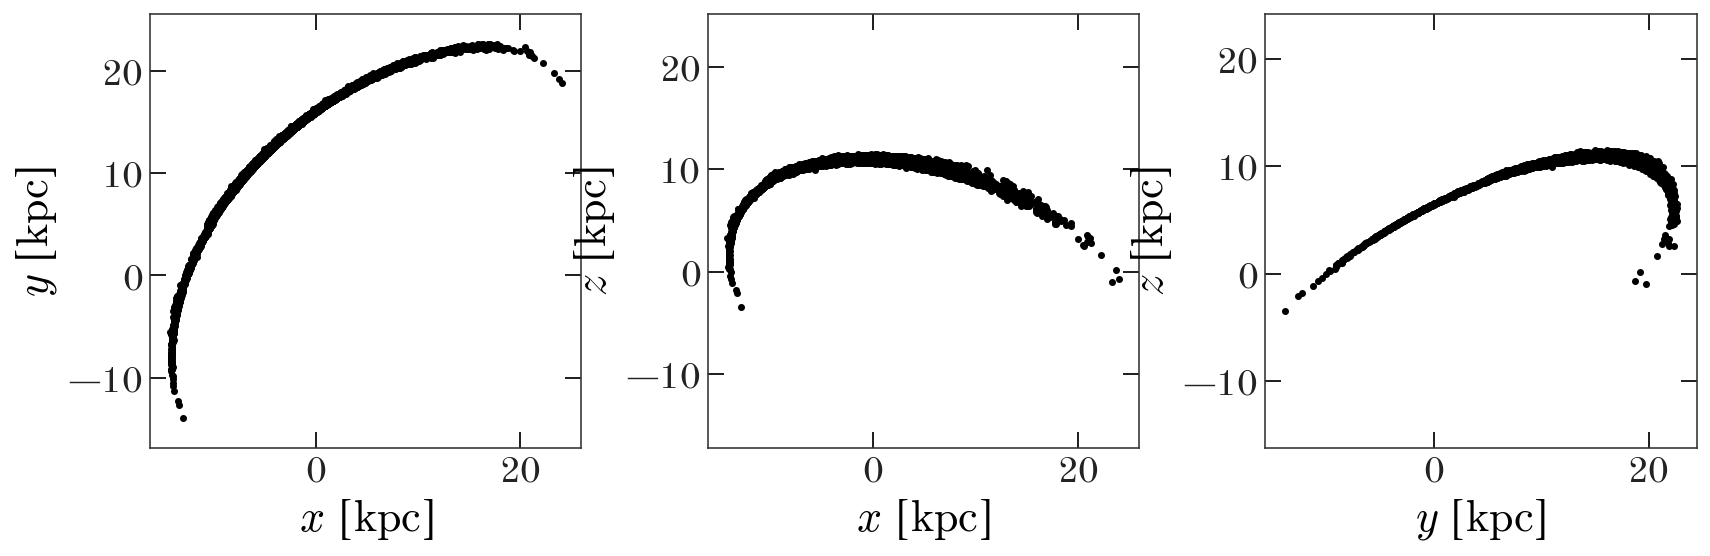

In [12]:
_ = fiducial_stream.plot()

In [22]:
tmp_stream_c = fiducial_stream.to_coord_frame(gc.GD1, galcen_frame)

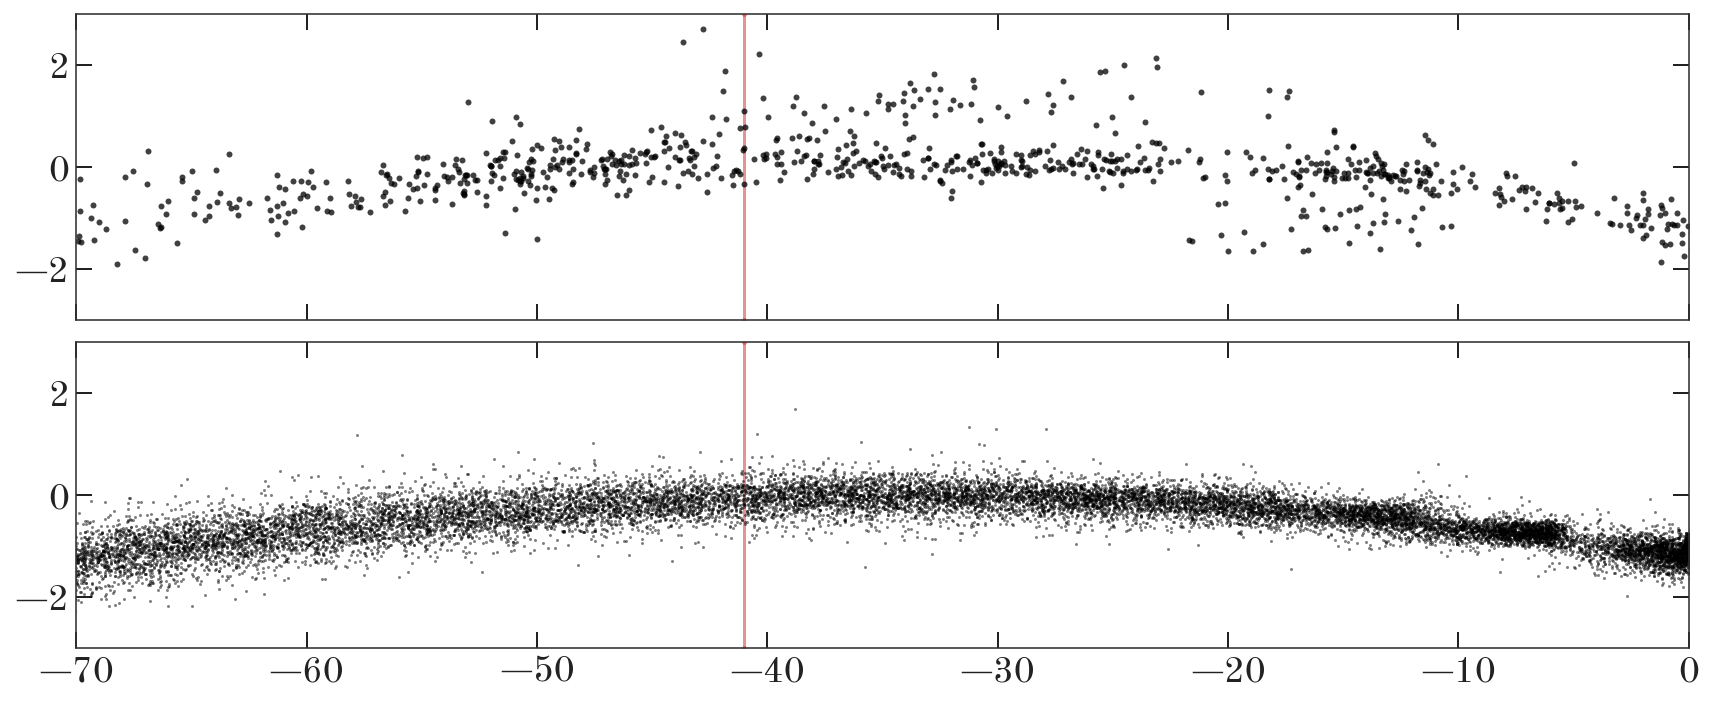

In [42]:
fig, axes = plt.subplots(2, 1, figsize=(12, 5), sharex=True, sharey=True)

ax = axes[0]
ax.plot(gd1_skypos['phi1'], gd1_skypos['phi2'], 
        marker='o', ls='none', mew=0, ms=3, alpha=0.75)

ax = axes[1]
ax.plot(tmp_stream_c.phi1, tmp_stream_c.phi2, 
        marker='o', ls='none', mew=0, ms=1.5, alpha=0.5)

for ax in axes:
    ax.axvline(-41, zorder=-100, color='tab:red', alpha=0.5)

ax.set_xlim(-70, 0)
ax.set_ylim(-3, 3)

fig.tight_layout()

In [44]:
impact_site_mask = np.abs(tmp_stream_c.phi1 - -41*u.deg) < 1*u.deg
impact_today_w0 = gd.PhaseSpacePosition(
    pos=fiducial_stream[impact_site_mask].xyz.mean(axis=1),
    vel=fiducial_stream[impact_site_mask].v_xyz.mean(axis=1))

In [55]:
mask = ((tmp_stream_c.phi1 > -70*u.deg) &
        (tmp_stream_c.phi1 < -15*u.deg))
size = min(mask.sum(), 8192)
idx = np.random.choice(mask.sum(), size=size, replace=False)
sub_stream = fiducial_stream[mask][idx]

TODO: why is this periodic??

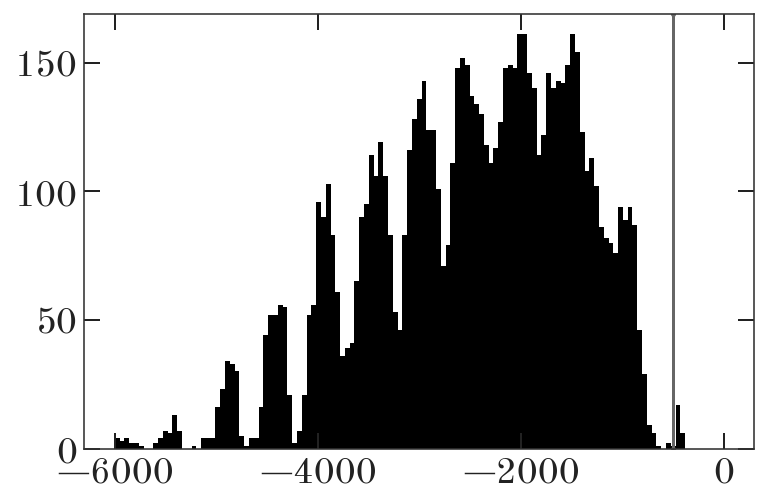

In [64]:
plt.hist(fiducial_stream.release_time[mask][idx].value, 
         bins=np.linspace(-6000, 0, 128));
plt.axvline(-500)

---

In [206]:
def impact_stream(perturber_potential, 
                  stream_w0, external_potential,
                  b, psi, vz, vpsi, tau,
                  impact_site_w0,
                  t_today=0., 
                  dt=0.25*u.Myr, coarse_dt_factor=4,
                  impact_dist_buffer=5*u.kpc):
    """
    Input phase-space coordinates are assumed to be in a Galactocentric frame.
    """
    assert tau < 0
    
    dt = np.abs(dt)  # used to resolve the impact
    coarse_dt = dt * coarse_dt_factor  # used to integrate after impact
    
    # Determine how much of a time buffer to use
    rel_v = np.sqrt(vz**2 + vpsi**2)
    t_buffer = (impact_dist_buffer / rel_v).to(u.Myr)
    t_buffer = int(t_buffer / dt) * dt  # round to factor of dt
    
    # Compute the orbit of the impact site
    impact_site_orbit = external_potential.integrate_orbit(
        impact_site_w0, dt=-1*u.Myr, t1=t_today, t2=tau,
        Integrator=gi.DOPRI853Integrator)
    site_at_impact_w0 = impact_site_orbit[-1]
    
    # Define a coordinate system at the time of impact such that the impact 
    # site velocity is aligned with the z axis, and the angular momentum is 
    # aligned with the x axis:
    L = site_at_impact_w0.angular_momentum()
    v = site_at_impact_w0.v_xyz
    
    new_z = v / np.linalg.norm(v, axis=0)
    new_x = L / np.linalg.norm(L, axis=0)
    new_y = -np.cross(new_x, new_z)
    R = np.stack((new_x, new_y, new_z))  # rotation matrix
    
    # Define the position of the perturber at the time of impact in the 
    # cylindrical impact coordinates:
    perturber_pos = coord.CylindricalRepresentation(rho=b, 
                                                    phi=psi, 
                                                    z=0*u.pc) # Fixed
    
    # Define the velocity in the cylindrical impact coordinates:
    perturber_vel = coord.CylindricalDifferential(
        d_rho=0*u.km/u.s, # Fixed
        d_phi=(vpsi/b).to(u.rad/u.Myr, u.dimensionless_angles()), 
        d_z=vz)
    
    # Transform from the cylindrical impact coordinates to Galactocentric
    perturber_rep = perturber_pos.with_differentials(perturber_vel)
    perturber_rep = perturber_rep.represent_as(
        coord.CartesianRepresentation, coord.CartesianDifferential)
    perturber_rep = perturber_rep.transform(R.T)

    pos = perturber_rep.without_differentials() + site_at_impact_w0.pos
    vel = perturber_rep.differentials['s'] + site_at_impact_w0.vel

    # This should be in Galactocentric Cartesian coordinates now!
    perturber_at_impact_w0 = gd.PhaseSpacePosition(pos, vel)
    
    # Integrate the perturber position to today:
    n_steps = ((t_today - tau) / (1*u.Myr)).decompose()
    tmp_t = np.linspace(tau.to_value(u.Myr),
                        t_today.to_value(u.Myr),
                        n_steps)
    perturber_orbit = external_potential.integrate_orbit(
        perturber_at_impact_w0, t=tmp_t,
        Integrator=gi.DOPRI853Integrator)
    perturber_today_w0 = perturber_orbit[-1]
    assert np.isclose(perturber_orbit.t[-1], t_today)
    
    # Combine the phase-space coordinates of the perturber and the 
    # stream particles that we are going to perturb
    w0_today = gd.combine(
        (perturber_today_w0, 
         gd.PhaseSpacePosition(stream_w0.pos, stream_w0.vel,
                               frame=perturber_today_w0.frame)))
    
    t1 = t_today
    t2 = tau - t_buffer
    n_steps = np.abs((t2 - t1) / (1*u.Myr)).decompose()
    tmp_t = np.linspace(t1.to_value(u.Myr),
                        t2.to_value(u.Myr),
                        n_steps)
    all_back_orbits = external_potential.integrate_orbit(
        w0_today, t=tmp_t, Integrator=gi.DOPRI853Integrator)
    all_w0_past = all_back_orbits[-1]
    t_past = all_back_orbits.t[-1]
    
    # Figure out time array:
    t_interaction = np.arange(t_past.to_value(u.Myr),
                              (tau + 2*t_buffer).to_value(u.Myr),
                              dt.to_value(u.Myr)) * u.Myr
    assert np.all(np.diff(t_interaction) > 0)

    # Now that we have the particle positions a little before the time of 
    # impact, we forward-simulate as an N-body system with the perturber. 
    # First, we set up the NBody object:
    ppots = [perturber_potential] + [None] * (w0_today.shape[0]-1)
    nbody = gd.DirectNBody(all_w0_past, particle_potentials=ppots, 
                           units=galactic, 
                           external_potential=external_potential,
                           save_all=True)
    orbits_impact = nbody.integrate_orbit(t=t_interaction)
    
    t_post = np.arange(orbits_impact.t[-1].to_value(u.Myr),
                       t_today.to_value(u.Myr),
                       coarse_dt.to_value(u.Myr)) 
    t_post = np.concatenate((t_post, 
                             [t_today.to_value(u.Myr)])) * u.Myr
    assert np.all(np.diff(t_post) > 0)
    orbits_post = H.integrate_orbit(orbits_impact[-1], 
                                    t=t_post,
                                    Integrator=gi.DOPRI853Integrator)
#                                     dt=coarse_dt, 
#                                     t1=orbits_impact.t[-1], 
#                                     t2=t_today+1e-1*u.Myr)
    
    orbits_impact = orbits_impact[::coarse_dt_factor]
    orbits_post = orbits_post[1:]

    new_data = coord.concatenate_representations((orbits_impact.data, 
                                                  orbits_post.data))
    new_t = np.concatenate((orbits_impact.t, orbits_post.t))
    new_orbit = gd.Orbit(new_data.xyz, new_data.differentials['s'].d_xyz, 
                         t=new_t)
    return new_orbit

In [232]:
# perturber_potential = gp.HernquistPotential(m=5e6*u.Msun, c=10*u.pc, units=galactic)
perturber_potential = gp.NFWPotential(m=5e6*u.Msun, r_s=15*u.pc, units=galactic)
# perturber_potential = gp.HernquistPotential(m=0*u.Msun, c=10*u.pc, units=galactic)

In [236]:
%%time
perturbed_stream = impact_stream(
    perturber_potential, 
    sub_stream, potential,
    b=15*u.pc, 
    psi=45*u.deg, 
    vz=-178*u.km/u.s, 
    vpsi=178*u.km/u.s, 
    tau=-495*u.Myr,
    impact_site_w0=impact_today_w0,
    dt=1.*u.Myr, coarse_dt_factor=4, 
    t_today=0*u.Myr)

CPU times: user 19.7 s, sys: 145 ms, total: 19.8 s
Wall time: 19.8 s


In [237]:
# assert np.all(np.abs(perturbed_stream[-1, 1:].xyz - sub_stream.xyz) < 1.*u.pc)

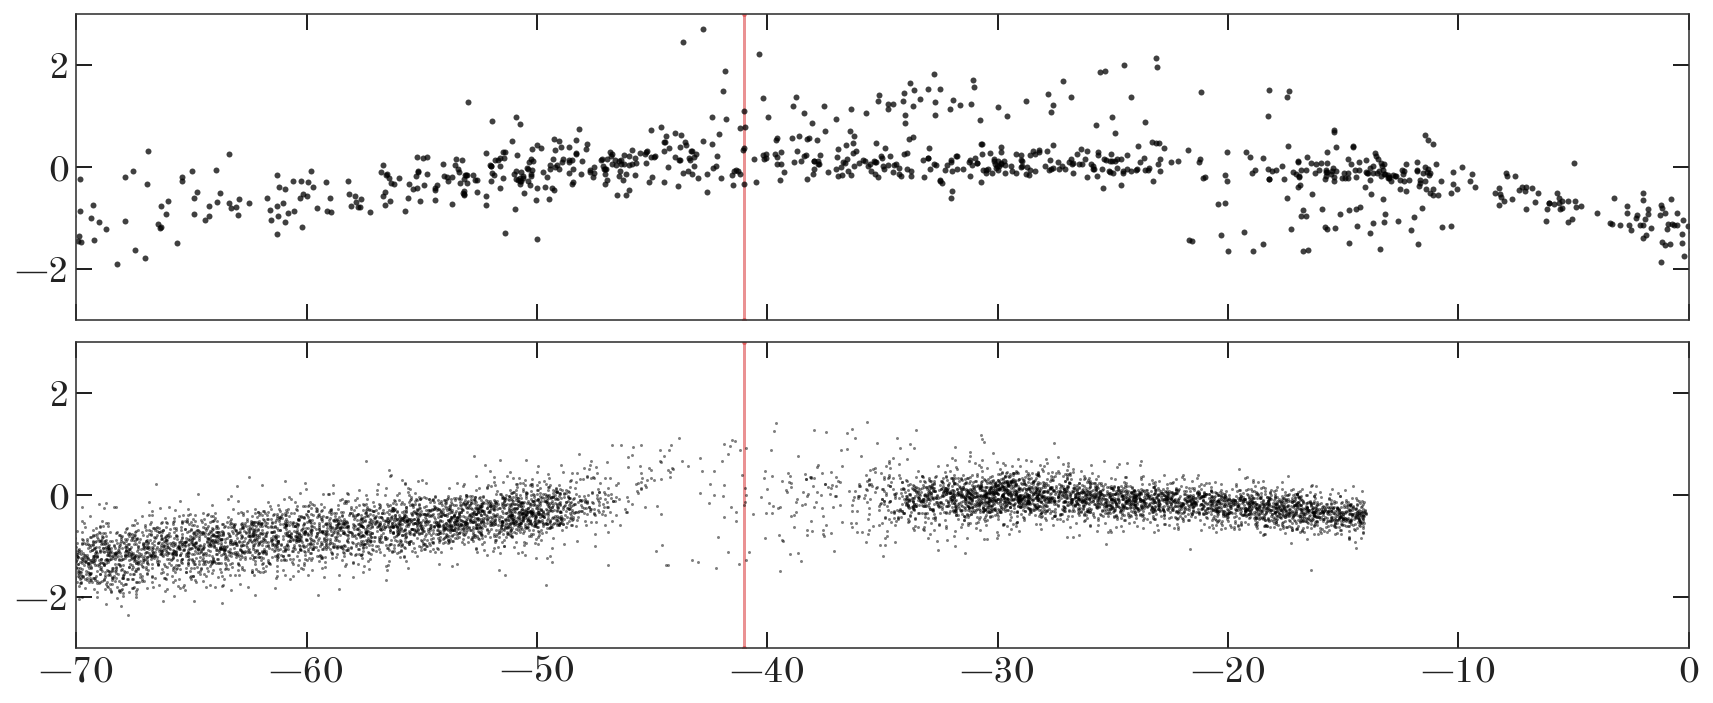

In [238]:
tmp_c = perturbed_stream[-1].to_coord_frame(gc.GD1Koposov10, galcen_frame)

fig, axes = plt.subplots(2, 1, figsize=(12, 5), sharex=True, sharey=True)

ax = axes[0]
ax.plot(gd1_skypos['phi1'], gd1_skypos['phi2'], 
        marker='o', ls='none', mew=0, ms=3, alpha=0.75)

ax = axes[1]
ax.plot(tmp_c.phi1, tmp_c.phi2, 
        marker='o', ls='none', mew=0, ms=1.5, alpha=0.5)

for ax in axes:
    ax.axvline(-41, zorder=-100, color='tab:red', alpha=0.5)

ax.set_xlim(-70, 0)
ax.set_ylim(-3, 3)

fig.tight_layout()

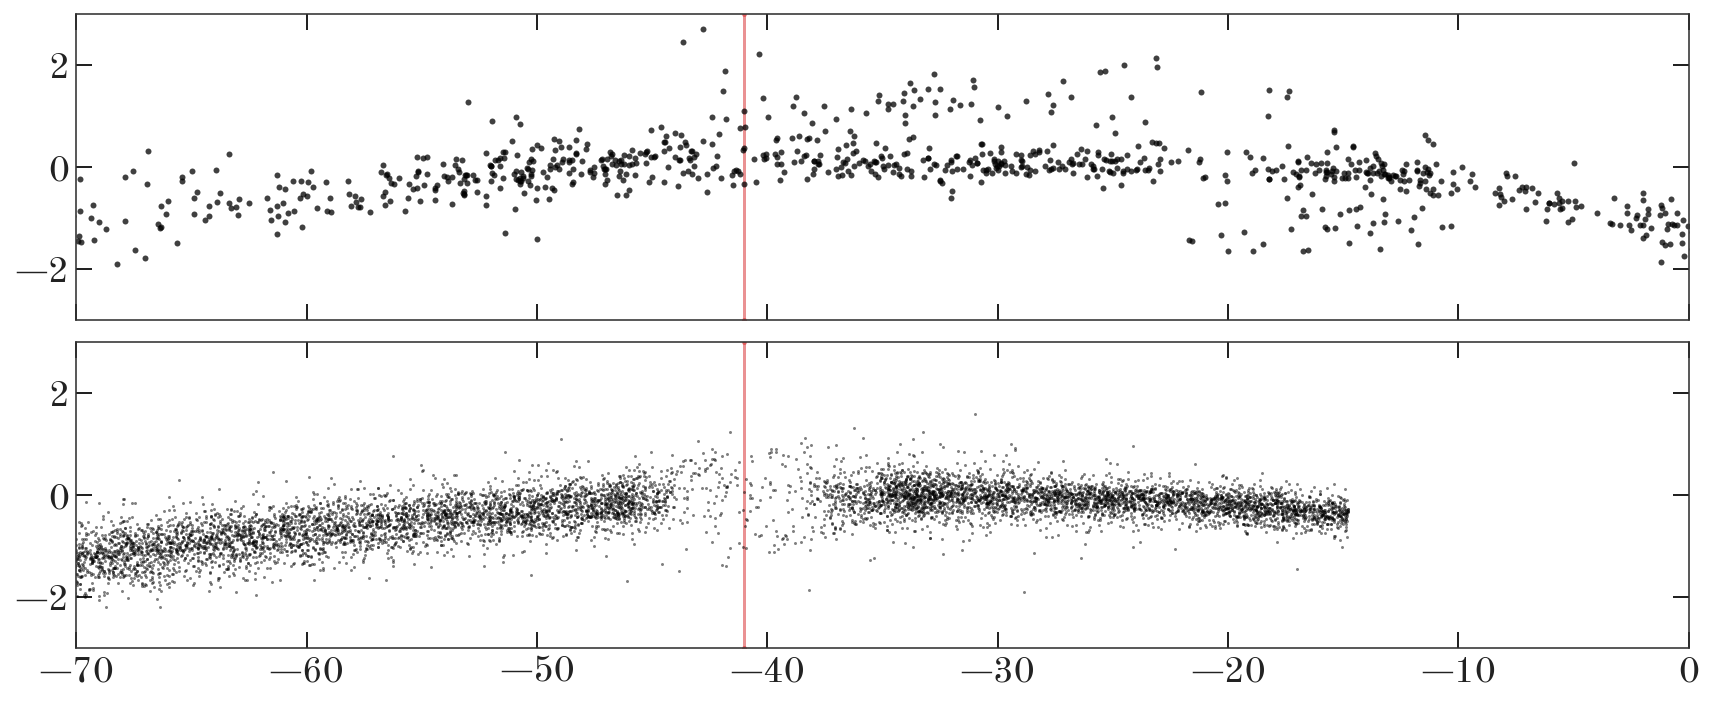

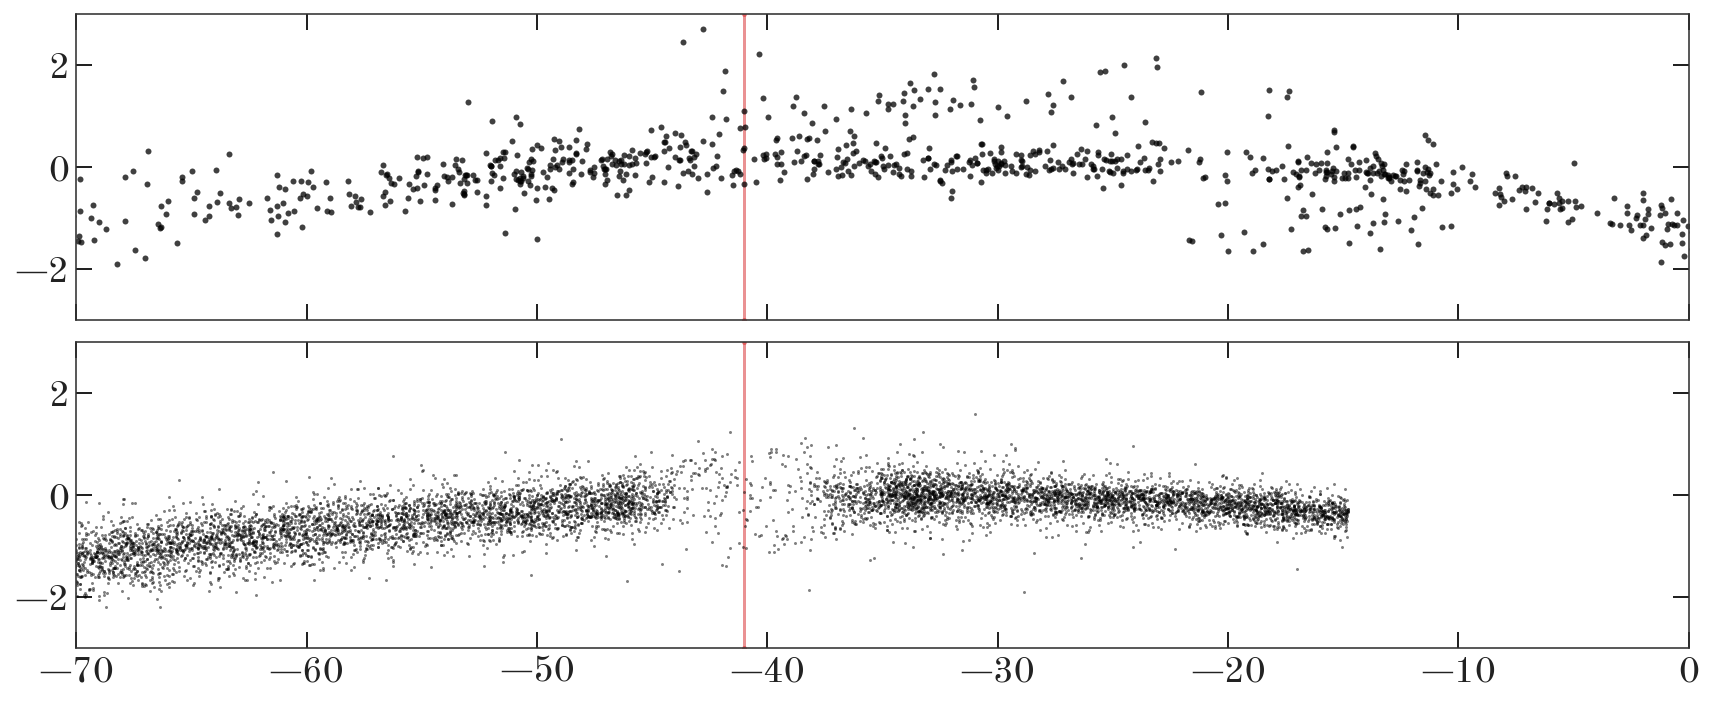

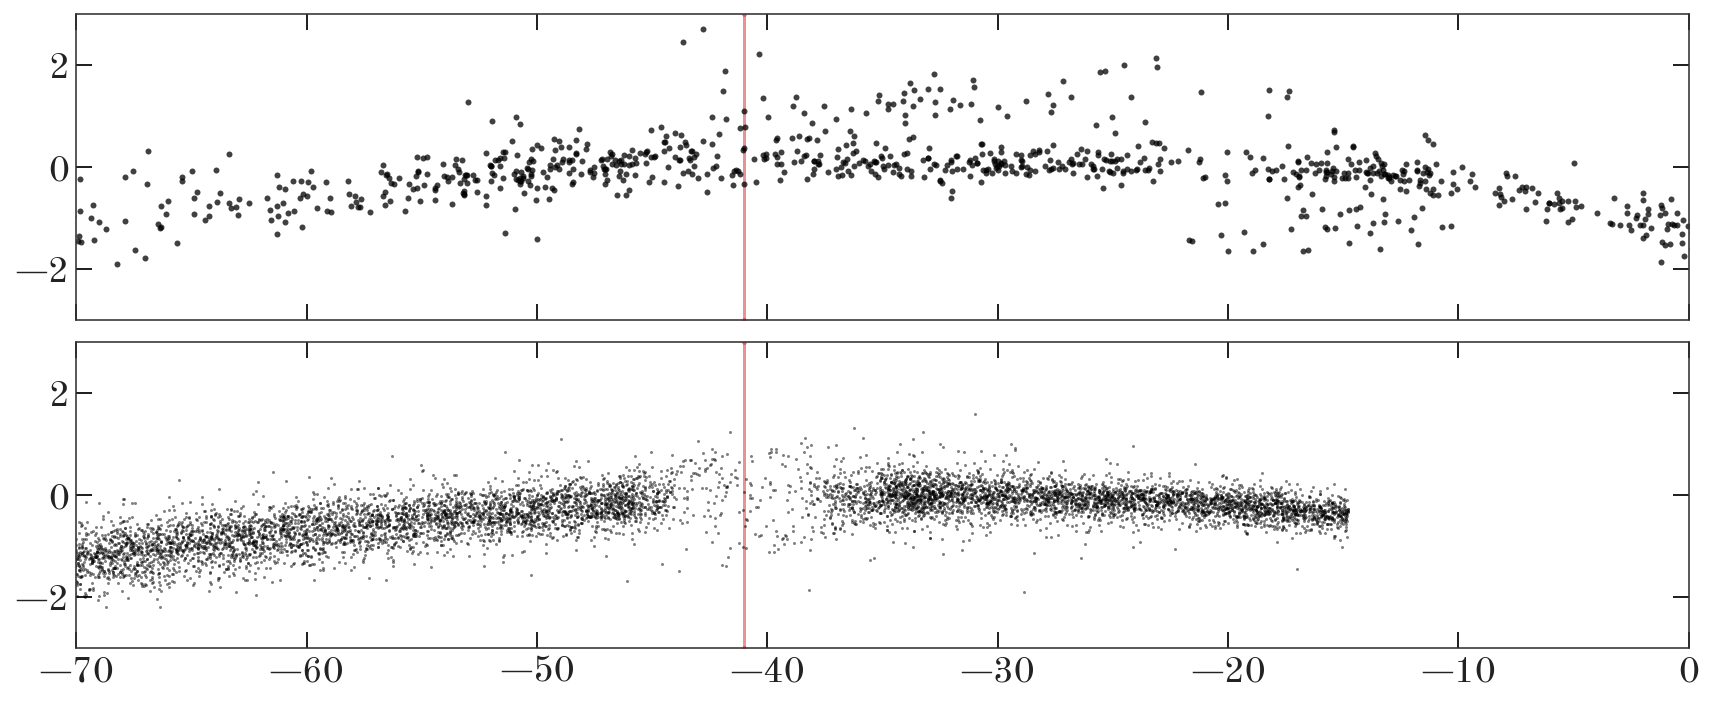

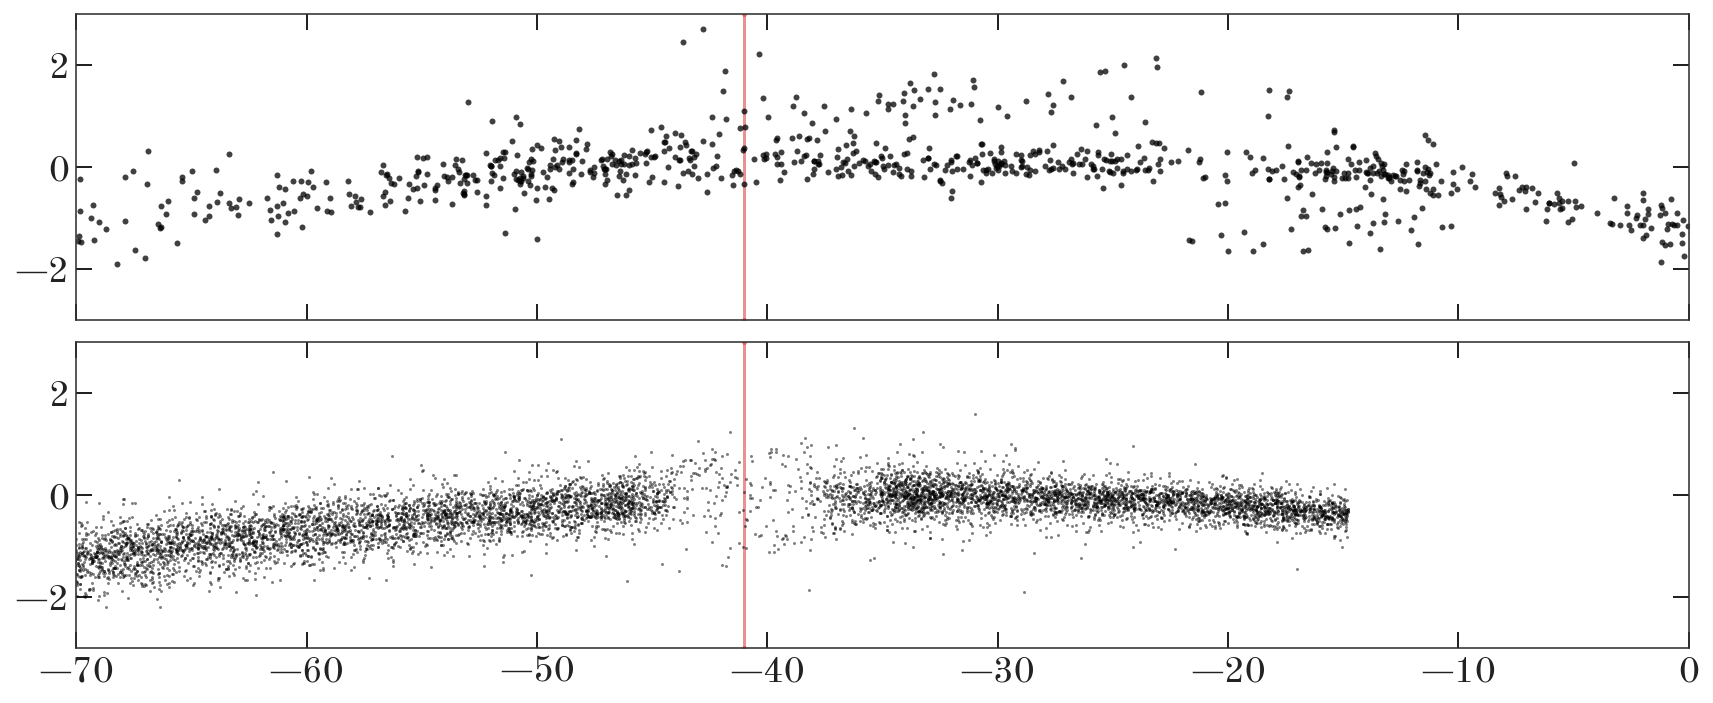

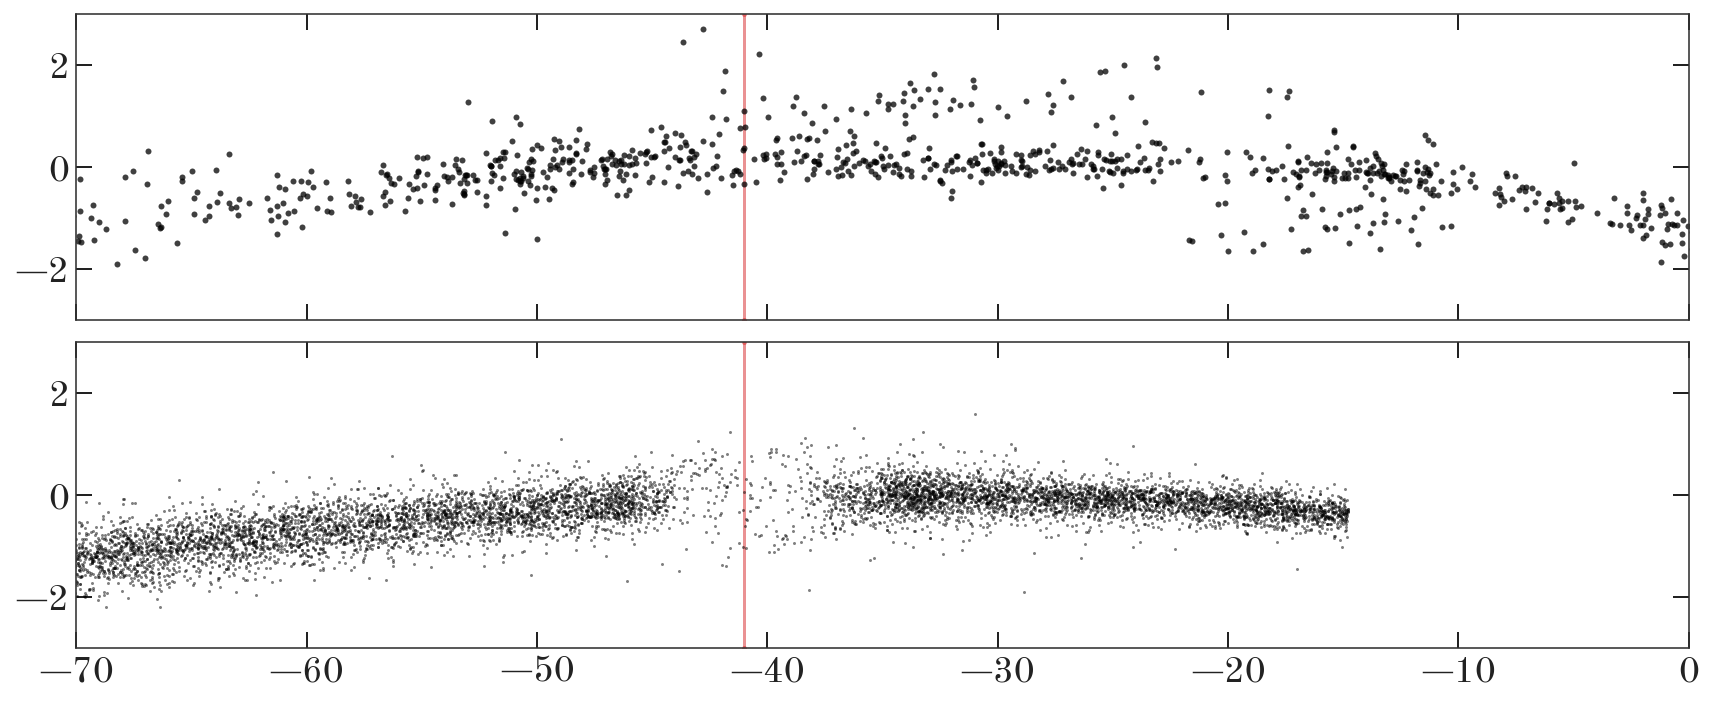

In [221]:
# for dt, fac in [(1., 2), (0.5, 4), (0.2, 10), (0.1, 20), (0.05, 40)]:
#     perturbed_stream = impact_stream(
#         perturber_potential, 
#         sub_stream, potential,
#         b=15*u.pc, 
#         psi=0*u.deg, 
#         vz=178*u.km/u.s, 
#         vpsi=178*u.km/u.s, 
#         tau=-495*u.Myr,
#         impact_site_w0=impact_today_w0,
#         dt=dt*u.Myr, coarse_dt_factor=fac, 
#         t_today=0*u.Myr)
    
#     tmp_c = perturbed_stream[-1].to_coord_frame(gc.GD1Koposov10, galcen_frame)

#     fig, axes = plt.subplots(2, 1, figsize=(12, 5), sharex=True, sharey=True)

#     ax = axes[0]
#     ax.plot(gd1_skypos['phi1'], gd1_skypos['phi2'], 
#             marker='o', ls='none', mew=0, ms=3, alpha=0.75)

#     ax = axes[1]
#     ax.plot(tmp_c.phi1, tmp_c.phi2, 
#             marker='o', ls='none', mew=0, ms=1.5, alpha=0.5)

#     for ax in axes:
#         ax.axvline(-41, zorder=-100, color='tab:red', alpha=0.5)

#     ax.set_xlim(-70, 0)
#     ax.set_ylim(-3, 3)

#     fig.tight_layout()

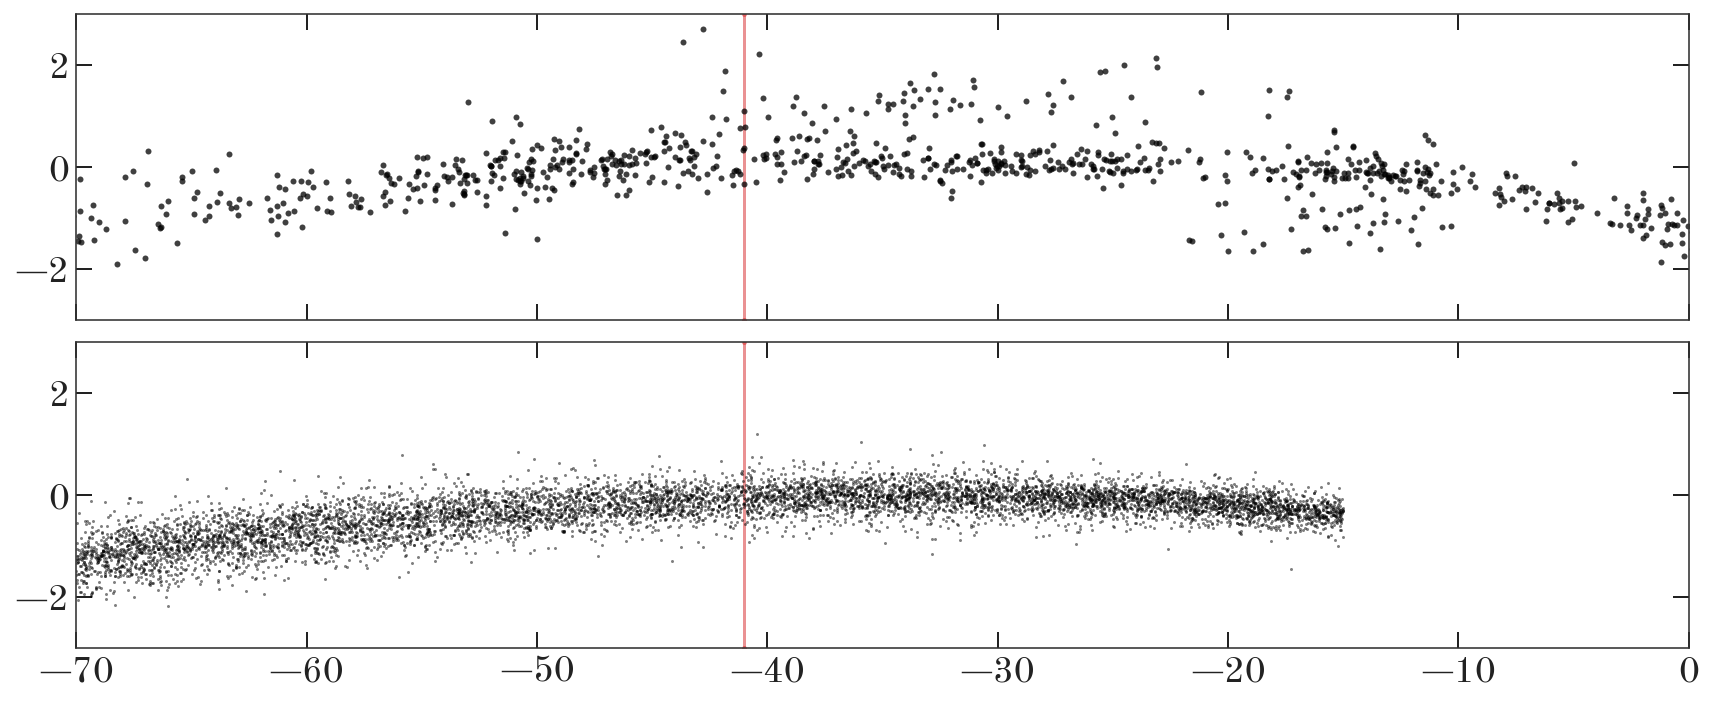

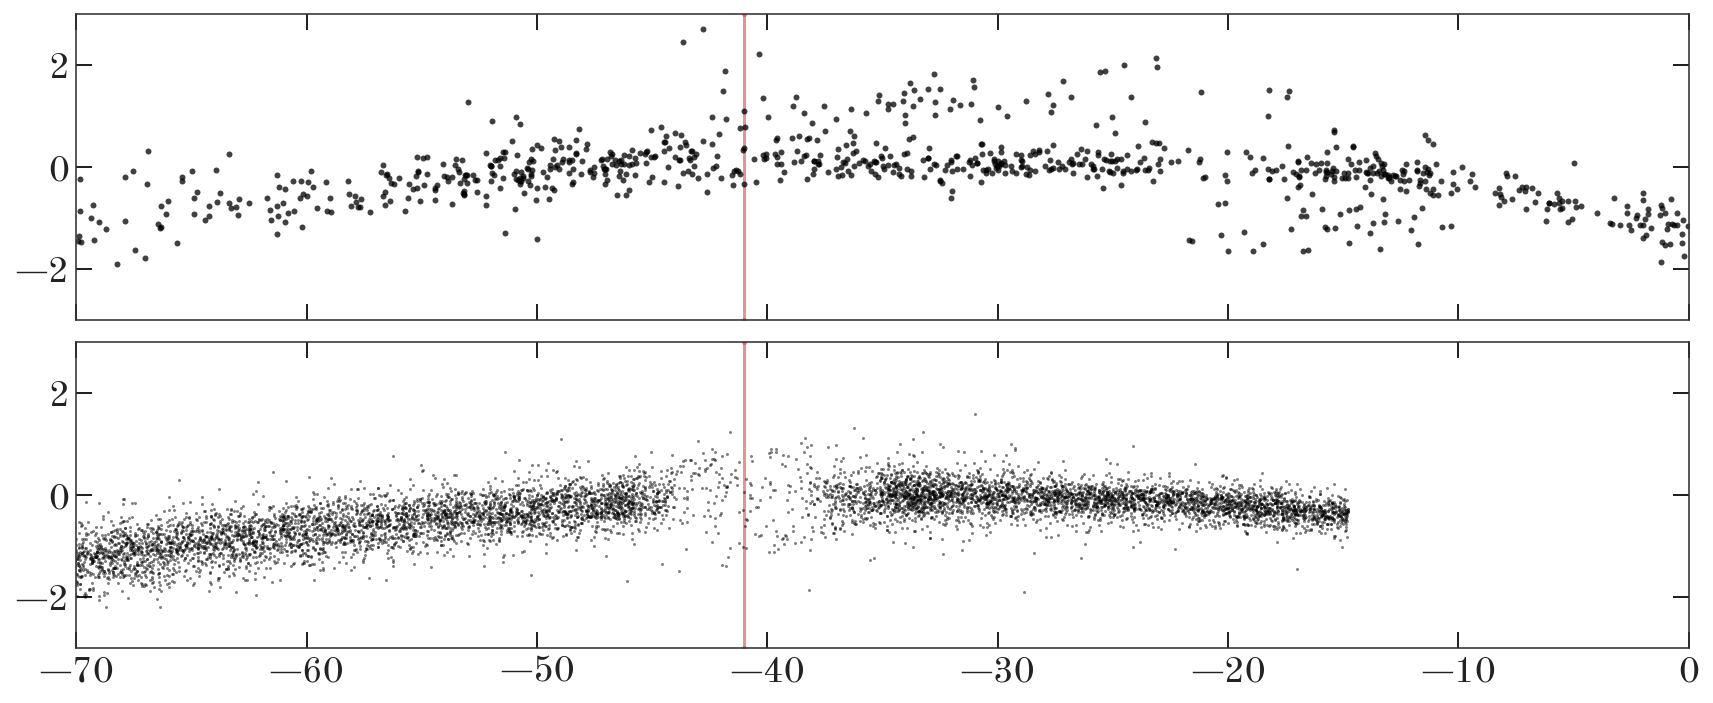

In [215]:
# for tmp_c in [sub_stream.to_coord_frame(gc.GD1Koposov10, galcen_frame),
#               perturbed_stream[-1].to_coord_frame(gc.GD1Koposov10, galcen_frame)]:

#     fig, axes = plt.subplots(2, 1, figsize=(12, 5), sharex=True, sharey=True)

#     ax = axes[0]
#     ax.plot(gd1_skypos['phi1'], gd1_skypos['phi2'], 
#             marker='o', ls='none', mew=0, ms=3, alpha=0.75)

#     ax = axes[1]
#     ax.plot(tmp_c.phi1, tmp_c.phi2, 
#             marker='o', ls='none', mew=0, ms=1.5, alpha=0.5)

#     for ax in axes:
#         ax.axvline(-41, zorder=-100, color='tab:red', alpha=0.5)

#     ax.set_xlim(-70, 0)
#     ax.set_ylim(-3, 3)

#     fig.tight_layout()